# TM10007 Group 4 -- ECG Data

In this assignment we wil test certain classifiers in order to create a classifier model to distinguish between normal and abnormal ECG's

In [1]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

pd.set_option('display.max_rows', 5)



## 1. Data loading, cleaning and visualization

Below we load the ECG data, convert it to a dataframe an clean the data.First we are going to start with loading the CS file into a dataframe

In [2]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

df = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(df.index)}')
print(f'The number of columns: {len(df.columns)}')

Cloning into 'TM10007_ML_ECG_group4'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 262 (delta 102), reused 60 (delta 43), pack-reused 124
Receiving objects: 100% (262/262), 69.49 MiB | 41.23 MiB/s, done.
Resolving deltas: 100% (139/139), done.
The number of samples: 827
The number of columns: 9001


Now we are going to test if there is data missing in our dataset. We conclude that NaNs are missing data and if an entire row or column has zero's, this is also seen as missing data.

In [3]:
# Checking if there are any NaN or None values in the dataset
print(f'Are there any NaN or None values in the dataset? = '+ str(df.isnull().values.any()))

Are there any NaN or None values in the dataset? = False


In [4]:
# Test dataset for missing rows/columns

# Columns
columnswithzeros = []
for (colname, colval) in df.iteritems():
  if (colval.to_numpy()==0).all() == True:
    print(f'All values are zero in column {colname}')
    columnswithzeros.append(colname)

if len(columnswithzeros) == 0:
  print('There are no columns with only zeros')
  
# Rows
rowswithzeros = []
for (index, rowval) in df.iterrows():
  if (rowval.to_numpy()==0).all() == True: 
    print(f'All values are zero in row {index}')
    rowswithzeros.append(index)

if len(rowswithzeros) == 0:
  print('There are no rows with only zeros')

There are no columns with only zeros
There are no rows with only zeros


Lasty we are going to check if there are patiens or features with multiple zeros in order to see if those zero's could represent missing data

In [5]:
# Test patients with multiple zero's 
def check_for_zeros_in_patients(dataframe): 
  patients_with_zeros=[]
  for (index, rowval) in dataframe.iterrows():
    row = rowval.to_numpy()[:-1] #change to numpy to delete row names en the last row of labels
    if (row==0).any() == True: #if there is a zero in the row
      number_of_zeros = 0
      for i in range(len(row)): #check the entire length of the row for
        if row[i] == 0:
          number_of_zeros += 1
      patients_with_zeros.append({"patient number": index, "number of zeros": number_of_zeros}) 
  print(patients_with_zeros)
  print(f' There are {len(patients_with_zeros)} patients with zeros')

check_for_zeros_in_patients(df)

# Test features with multiple zero's
def check_for_zeros_in_features(dataframe):
  features_with_zeros = []
  for (colname, colval) in dataframe.iteritems():
    if colname == "label": #don't check the column label
      continue
    col = colval.to_numpy()
    if (col==0).any() == True: 
      number_of_zeros = 0
      for i in range(len(col)):
        if col[i] == 0:
          number_of_zeros += 1
      features_with_zeros.append({"feature": colname, "number of zeros": number_of_zeros}) 

  print(features_with_zeros)
  print(f'There are {len(features_with_zeros)} features with zeros')

check_for_zeros_in_features(df)

[{'patient number': 177, 'number of zeros': 750}, {'patient number': 251, 'number of zeros': 750}, {'patient number': 269, 'number of zeros': 750}, {'patient number': 321, 'number of zeros': 750}, {'patient number': 323, 'number of zeros': 750}, {'patient number': 385, 'number of zeros': 750}, {'patient number': 434, 'number of zeros': 750}, {'patient number': 446, 'number of zeros': 750}, {'patient number': 537, 'number of zeros': 750}, {'patient number': 542, 'number of zeros': 750}, {'patient number': 575, 'number of zeros': 750}, {'patient number': 601, 'number of zeros': 750}, {'patient number': 784, 'number of zeros': 750}, {'patient number': 790, 'number of zeros': 750}]
 There are 14 patients with zeros
[{'feature': '6_0', 'number of zeros': 1}, {'feature': '6_1', 'number of zeros': 1}, {'feature': '6_2', 'number of zeros': 1}, {'feature': '6_3', 'number of zeros': 1}, {'feature': '6_4', 'number of zeros': 1}, {'feature': '6_5', 'number of zeros': 1}, {'feature': '6_6', 'number

Conclusion: there are patients with multiple zero's (14 with 750 zero's), however these are not centered at certain features. This means that these zero's could indeed represent missing data and are therefore be replaced with the mean of that feature for the label of that patient.


In [6]:
# Create a list of means per label and feature
df_normal = df[df["label"]== 0]
df_abnormal = df[df["label"]== 1]
df_normal_mean = {}
df_abnormal_mean = {}

for (colname, colval) in df_normal.iteritems():
  if colname == "label":
    continue
  df_normal_mean[colname] = (colval.to_numpy().mean())

for (colname, colval) in df_abnormal.iteritems():
   if colname == "label":
     continue
   df_abnormal_mean[colname] = (colval.to_numpy().mean())

print(df_normal_mean)
print(df_abnormal_mean)

{'0_0': 469.3470502749906, '0_1': 70.6996088100883, '0_2': 40.62862319412772, '0_3': 31.173712757341196, '0_4': 31.54865255065674, '0_5': 43.429041907720126, '0_6': 55.84330178557533, '0_7': 39.003234790730296, '0_8': 25.226056527835073, '0_9': 19.172557363950904, '0_10': 22.256479757512093, '0_11': 26.297794080493855, '0_12': 30.72142554697234, '0_13': 31.66812879477023, '0_14': 30.372431869497436, '0_15': 31.39360833307335, '0_16': 33.352713458528626, '0_17': 34.58298517061866, '0_18': 38.503790736701596, '0_19': 38.319370868571966, '0_20': 43.68758295776539, '0_21': 35.40656152935558, '0_22': 34.785388992521355, '0_23': 35.78567016939342, '0_24': 34.731802677249625, '0_25': 30.919289833729547, '0_26': 28.888807336884312, '0_27': 25.994899925065507, '0_28': 25.159825027510696, '0_29': 25.99326216312191, '0_30': 28.119506596374972, '0_31': 30.27387223375175, '0_32': 31.95308050038741, '0_33': 30.74525789346074, '0_34': 31.30504561055703, '0_35': 31.8473466118405, '0_36': 32.1852669540

In [7]:
# Replace zeros with the correct mean of that feature and label
cleaned_data = df.copy().to_numpy() #make a copy of original data and change into numpy array

column_names = list(df.columns.values) #make a list of the column names

for i in range(len(cleaned_data)):
  for j in range(len(cleaned_data[0])-1):
    if cleaned_data[i,j] == 0:
      label = cleaned_data[i,-1]
      if label == 0:
        col_name = column_names[j]
        cleaned_data[i,j] = df_normal_mean[col_name]
      else:
        col_name = column_names[j]
        cleaned_data[i,j] = df_abnormal_mean[col_name]

# Change back from numpy array to dataframe and check if there are no zeros left and the dimension are the same
cleaned_df = pd.DataFrame(cleaned_data, columns = column_names)
print(f'The number of samples: {len(cleaned_df.index)}')
print(f'The number of columns: {len(cleaned_df.columns)}')
check_for_zeros_in_patients(cleaned_df)
check_for_zeros_in_features(cleaned_df)

The number of samples: 827
The number of columns: 9001
[]
 There are 0 patients with zeros
[]
There are 0 features with zeros


Lastly we want to categorize our dataset to see how many patients have a normal and how many patients have an abnormal ECG. 


In [8]:
# How many patients have a normal or abnormal ECG?
count0= (cleaned_df['label'] == 0).sum()
count1= (cleaned_df['label'] == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')
# Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal

There are 681 patients with label 0
There are 146 patients with label 1


## 2. Initial split
Below we split the dataset in test data and training data. 

In [9]:
# Split the whole data set in a training and test set
features = cleaned_df.loc[:, cleaned_df.columns !="label"].to_numpy()
labels = cleaned_df["label"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split (features, labels, train_size = 0.8, random_state = 42) 

## 3. Determining the scaling method, PCA settings and type of feature selection and combine all combinations.


There are multiple ways to scale features. Since the feature distribution is unclear, we will use normalization.

In [22]:
# # 1. Standardization of the data
# scaler_standard = StandardScaler()
# x_scaled_standard = scaler_standard.fit_transform(x_train) --> gezien we distributie niet zeker weten gooien we deze weg

# 1. Min-max scaling
scaler_minmax = MinMaxScaler()
x_scaled_minmax = scaler_minmax.fit_transform(x_train)

# 2. Robust scaling
scaler_robust= RobustScaler()
x_scaled_robust = scaler_robust.fit_transform(x_train)

x_scaled = {"minmax":x_scaled_minmax, "robust": x_scaled_robust}


Now we are going to perform PCA and determine the treshold.

(661, 306)


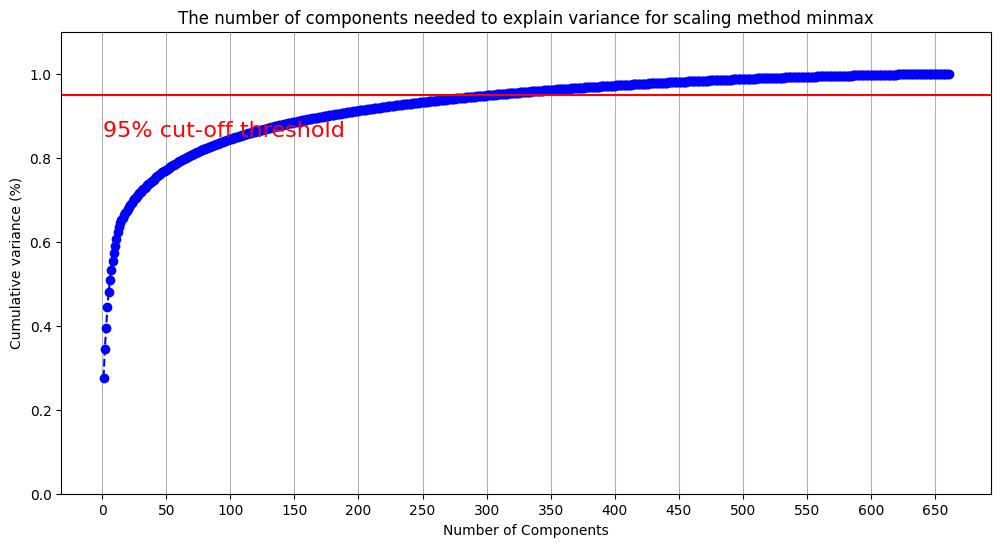

(661, 124)


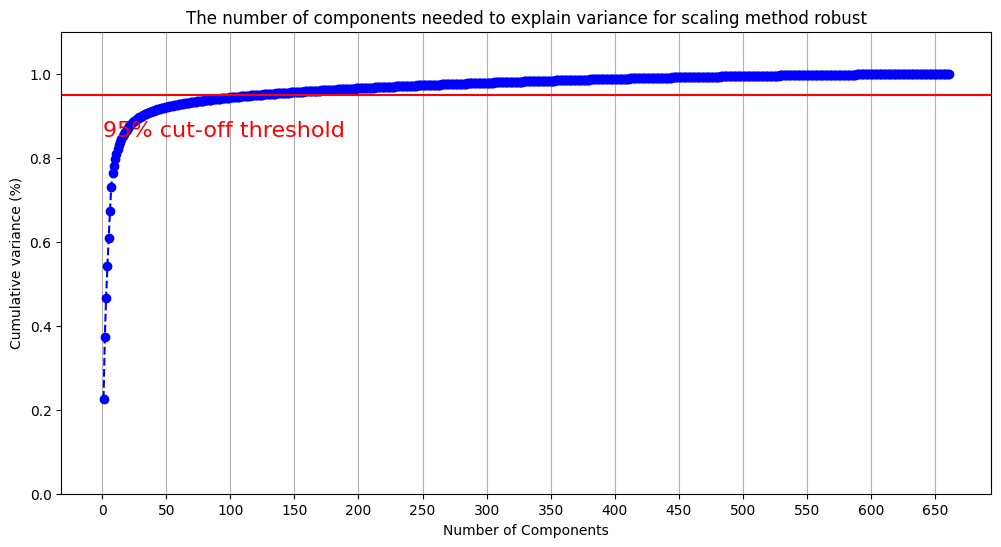

{'x_minmax_PCA': array([[-9.18164187e-01,  8.85911876e-01, -3.42927016e-01, ...,
        -7.61448202e-02, -3.30267718e-02,  1.54194853e-01],
       [-1.52301664e+00, -4.82151018e-01, -1.90918214e-01, ...,
         1.85823893e-01,  1.29499028e-01,  2.33477977e-02],
       [-5.05013316e+00, -3.57324996e-01, -6.35028423e-01, ...,
         2.01466434e-02, -6.82225981e-03, -8.55933313e-04],
       ...,
       [-6.55827319e-01,  1.73964424e+00, -4.42065467e-01, ...,
        -5.22581447e-02, -4.51606295e-02, -1.82184768e-01],
       [-2.22615903e+00, -1.61628123e+00,  1.20760205e-01, ...,
         2.61523202e-01,  1.73543856e-01, -9.85690482e-02],
       [ 1.78125460e+01, -7.98177140e+00,  1.77865391e+00, ...,
        -1.15263165e-01, -1.95100576e-01,  2.06323022e-02]]), 'x_robust_PCA': array([[-2.64041815e+01,  1.38562302e+01, -2.59522570e+00, ...,
         2.73583613e+00,  1.51689370e+00,  2.16635199e+00],
       [-3.30447703e+01,  1.17776277e+01, -3.99161372e+00, ...,
        -2.47042849e+

In [24]:
# PCA

x_scaled_pca = {}

for key, x in x_scaled.items():
  # applying pca
  pca_setting = PCA(n_components = 0.95) # threshold at 95% method
  x_pca = pca_setting.fit_transform(x)
  x_scaled_pca[f"x_{key}_PCA"] = x_pca

  print(x_pca.shape)

  # plot to show treshold choice
  pca_figure = PCA().fit(x)
  plt.rcParams["figure.figsize"] = (12,6)

  fig, ax = plt.subplots()
  xi = np.arange(1, 662, step=1)
  y = np.cumsum(pca_figure.explained_variance_ratio_)

  plt.ylim(0.0,1.1)
  plt.plot(xi, y, marker='o', linestyle='--', color='b')

  plt.xlabel('Number of Components')
  plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
  plt.ylabel('Cumulative variance (%)')
  plt.title(f'The number of components needed to explain variance for scaling method {key}')

  plt.axhline(y=0.95, color='r', linestyle='-')
  plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

  ax.grid(axis='x')
  plt.show()

## 4. Creating pipelines of feature scaling, extraction and selection.
Below we create 4 different pipelines with various combinations of the chosen feature scaling and selection methods in combination with PCA.

In [11]:
# Pipeline

Hallo tekst

Hallo tekst

In [13]:
# Different feature selection

Hallo tekst

In [25]:
# Different feature selection
np.logspace(-2, 3, 6)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

## 5. Determining the best combination of feature scaling, selection and classifier
In this section we will train our different clasiffiers and compare their functionality in terms of accuracy. We will perform this for all possible combinations of scaling, selection and classification possibilities. This is also the section were we will tune our parameters.

First we are going to set the models and parameters we are going to tune and write the function for tuning. 

In [46]:
# Creating a dictionary of all proposed classifiers
models = {"GaussianNB": GaussianNB(),
          "DecisionTreeClassifier":DecisionTreeClassifier(),
          "KNeighborsClassifier": KNeighborsClassifier(),
          "RandomForestClassifier":RandomForestClassifier(),
          "SVC":SVC()}


# Creating a dictionary of all models with default paramters (note; random state=42 only added in the last run)
model_parameters = {"GaussianNB": {}, #no parameters to be set
                    "DecisionTreeClassifier": {"max_depth": [x for x in range (1,10)], "min_samples_leaf":[x for x in range (4,20)]},
                    "KNeighborsClassifier":{"n_neighbors":[x for x in range(1, 200)], "weights": ["distance", "uniform"]},
                    "RandomForestClassifier":{"n_estimators":[x for x in range(5,10)], "max_depth":[x for x in range (1,10)], "min_samples_leaf": [x for x in range (4, 20)]},
                    "SVC":{"C": np.logspace(-2, 4, num=50), "kernel": ["linear", "rbf", "poly"], "degree":[x for x in range (2,6)]}}

# Function to clean up results and create dataframe with wanted results
def get_dataframe_from_results(results, scoring):
  """ This function makes sure that we can clean up the results that we get from the grid search and leaves is with the necessary results"""
  df_to_concat = [pd.DataFrame(results["params"])]

  for key in scoring:
    df_to_concat.append(pd.DataFrame(results[f"mean_test_{key}"], columns=[key]))

  return pd.concat(df_to_concat, axis=1)

# Function to do a grid search on each model using the parameters in the model_parameter dictionary
def parametertuning(Models, ModelParameters, n_splits, random_state, scoring, refit, X, Y):
  """ This function performs the parameter tuning by doing a gridsearch with multiple parameters per model it returns the results that are cleaned up and only show the necessary"""
  results = {} #create a dictionary to save results

  for model_name, parameters in ModelParameters.items():
    print(f"Grid searching {model_name}")
    model = Models[model_name]  # Find corresponding model in models dict

    # Create the Cross vallidation object
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)  
    
    # Perform a grid search for the best parameters for the model using the test data and KFold
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring, refit=refit).fit(X, Y) 
    
    # Results of grid search
    best_estimator = grid_search.best_estimator_ # Returns the model with the best parameters filled in based on accuracy
    grid_search_results = get_dataframe_from_results(grid_search.cv_results_, scoring) # Extracts the necessary results (parameters with their corresponding accuracy)

    # Add the results to the dictionary
    results[model_name] = {"BestEstimator": best_estimator, "GSresults": grid_search_results}
 
  return results

Now we are going write the function to plot the relation between the scoring type and certain parameters in order to prove that we chose the right parameter combinations.

In [47]:
# Since we do not tune any paramters in GaussianNB we don't need to make a plot

#---------------Plot for DecisionTreeClassifier---------------
def plot_decisiontree(results, scoring, combination_name):
  tree_df = results["DecisionTreeClassifier"]["GSresults"]
  
  for key in scoring:
    index_maxscore = tree_df[key].idxmax()

    plt.scatter(tree_df["max_depth"].to_numpy(), tree_df["min_samples_leaf"].to_numpy(), linewidth = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = tree_df[key])
    plt.scatter(tree_df["max_depth"][index_maxscore], tree_df["min_samples_leaf"][index_maxscore], s = 200, marker = "*", c = "m")
    plt.colorbar()

    plt.title(f"The relation between the {key} of the Decision Tree Classifier and the parameters for {combination_name}")
    plt.xlabel("max_depth")
    plt.ylabel("min_samples_leaf")
    plt.show()

#---------------Plot for KNeighborsClassifier---------------
def plot_knn(results, scoring, combination_name):
  knn_df = results["KNeighborsClassifier"]["GSresults"]
  uni_knn_df = knn_df[knn_df["weights"] == "uniform"]
  dist_knn_df = knn_df[knn_df["weights"] == "distance"]

  for key in scoring:
    index_maxscore = knn_df[key].idxmax()

    plt.plot(uni_knn_df["n_neighbors"].to_numpy(), uni_knn_df[key].to_numpy(), label= "uniform")
    plt.plot(dist_knn_df["n_neighbors"].to_numpy(), dist_knn_df[key].to_numpy(), label= "distance")
    plt.scatter(knn_df["n_neighbors"][index_maxscore], knn_df[key].max(), s= 200, marker = "*", c="m")

    plt.legend()
    plt.title(f"The relation between the {key} of the KNN classifier and the parameters {combination_name}")
    plt.xlabel("N-neighbour")
    plt.ylabel(f"{key}")
    plt.show()

#---------------Plot for SVC Classifier--------------- 
def plot_svc(results, scoring, combination_name):
  svc_df = results["SVC"]["GSresults"]
  linear_svc_df = svc_df[svc_df["kernel"]=="linear"]
  rbf_svc_df = svc_df[svc_df["kernel"]=="rbf"]
  poly_svc_df = svc_df[svc_df["kernel"]=="poly"]

  for key in scoring:
    index_maxscore = svc_df[key].idxmax()

    for i in range(2,5):
      degree_svc_df = poly_svc_df[poly_svc_df["degree"]==i]
      plt.plot(degree_svc_df["C"].to_numpy(), degree_svc_df[key].to_numpy(), label= f"poly degree {i}")

    plt.plot(linear_svc_df["C"].to_numpy(), linear_svc_df[key].to_numpy(), label= "linear")
    plt.plot(rbf_svc_df["C"].to_numpy(), rbf_svc_df[key].to_numpy(), label= "rbf")
    plt.scatter(svc_df["C"][index_maxscore], svc_df[key].max(), s = 200, marker = "*", c="m")

    plt.legend()
    plt.title(f"The relation between the {key} of the SVC classifier and the parameters {combination_name}")
    plt.xscale("log")
    plt.xlabel("C-value")
    plt.ylabel(f"{key}")
    plt.show()

# ---------------Plots for RandomForestClassifier---------------
def plot_randomforest(results, scoring, combination_name):
  forest_df = results["RandomForestClassifier"]["GSresults"]

  for key in scoring:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    index_maxscore = forest_df[key].idxmax()

    x = forest_df["max_depth"].to_numpy()
    y = forest_df["min_samples_leaf"].to_numpy()
    z = forest_df["n_estimators"].to_numpy()
    c = forest_df[key].to_numpy()

    img = ax.scatter(x, y, z, c=c, cmap = plt.hot())
    ax.scatter(forest_df["max_depth"][index_maxscore], forest_df["min_samples_leaf"][index_maxscore], forest_df["n_estimators"][index_maxscore], marker = "*", s= 200, c= 'm')

    plt.title(f"The relation between the {key} of the Random Forest and the parameters {combination_name}")
    fig.colorbar(img, pad=0.1)
    ax.set_xlabel("max_depth")
    ax.set_ylabel("min_samples_leaf")
    ax.set_zlabel("n_estimators")
    
    for angle in range(0, 360):
       ax.view_init(30, 40)

    plt.show()

Beneath, we write the function to display the best scoring results for each model.

In [48]:
# Plot tabel with accuracy and optimal paramater combination per scalor and selection
def create_table_of_results(results, combination_name):
  accuracies = []
  AUC = []
  model_names = [] 

  for model_name in results:
    accuracy = results[model_name]["GSresults"]["Accuracy"].max()
    auc = results[model_name]["GSresults"]["AUC"].max()
    accuracies.append(accuracy)
    AUC.append(auc)
    model_names.append(model_name)

  print(f"Table of results for combination {combination_name}")  
  display(pd.DataFrame({"ModelName":model_names, "Accuracy":accuracies, "AUC":AUC}).style.hide_index())

Lastly, we will call all functions written to tune all the parameters and plot the results for each combination of scaling, PCA and selection.

Grid searching GaussianNB
Grid searching DecisionTreeClassifier
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier
Grid searching SVC


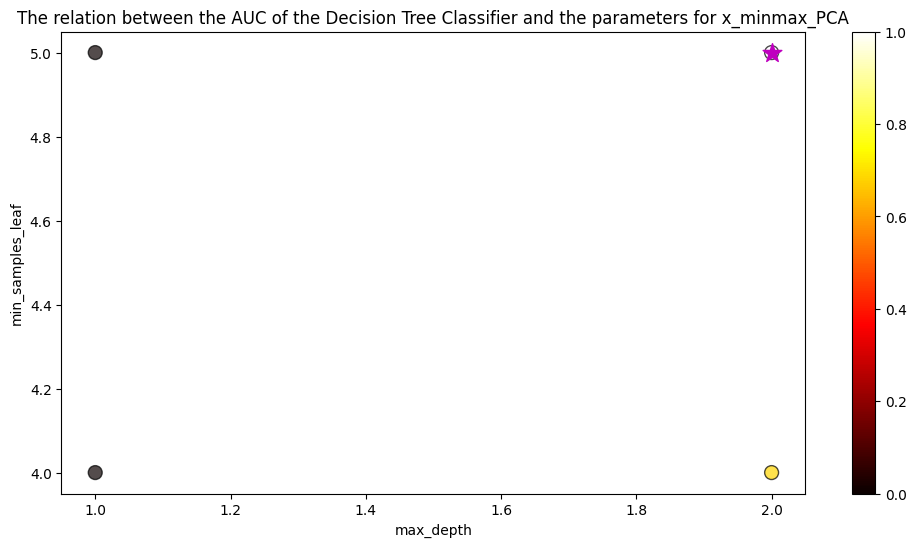

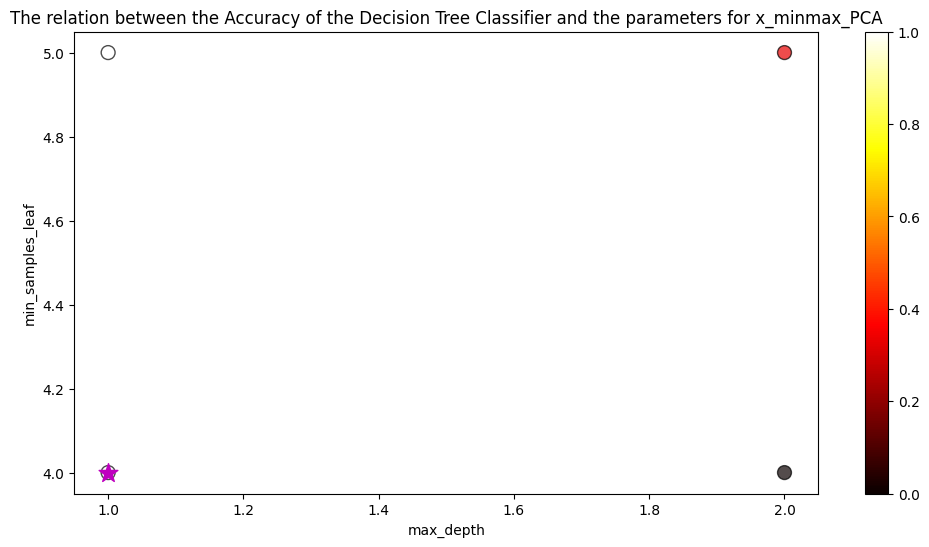

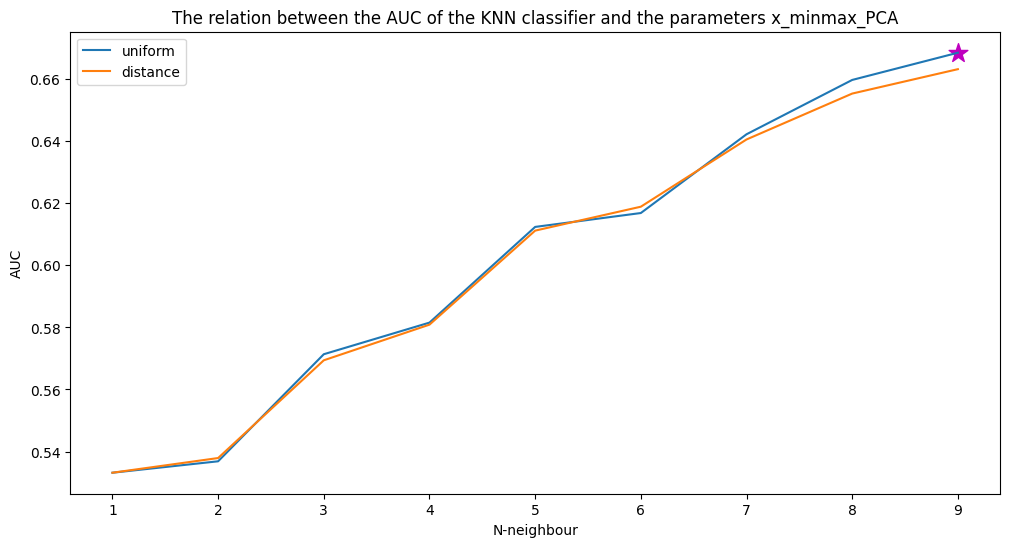

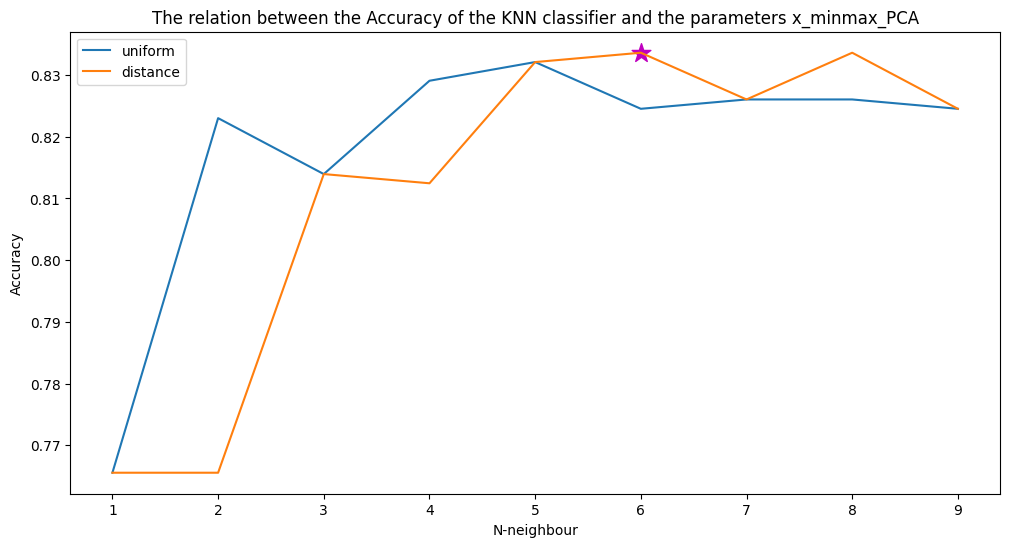

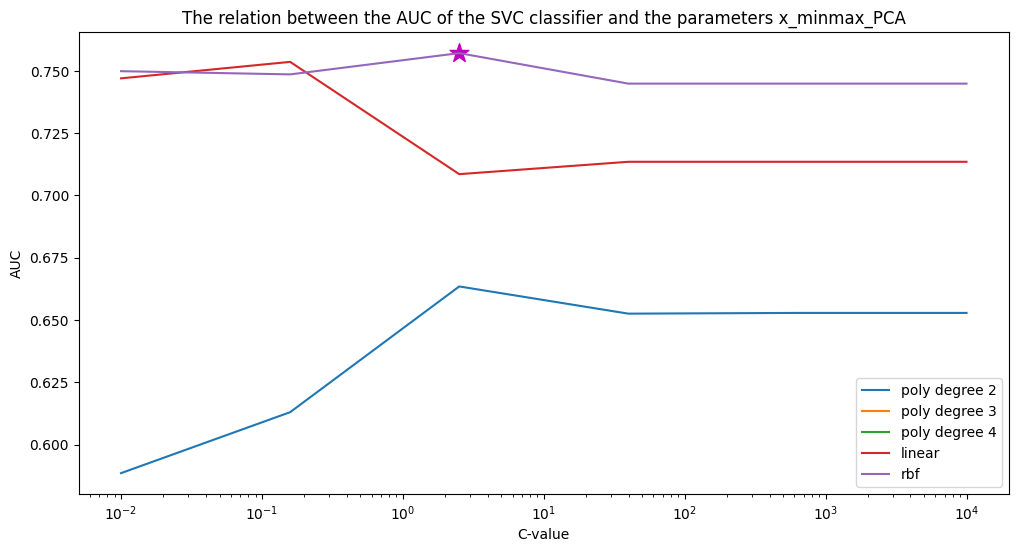

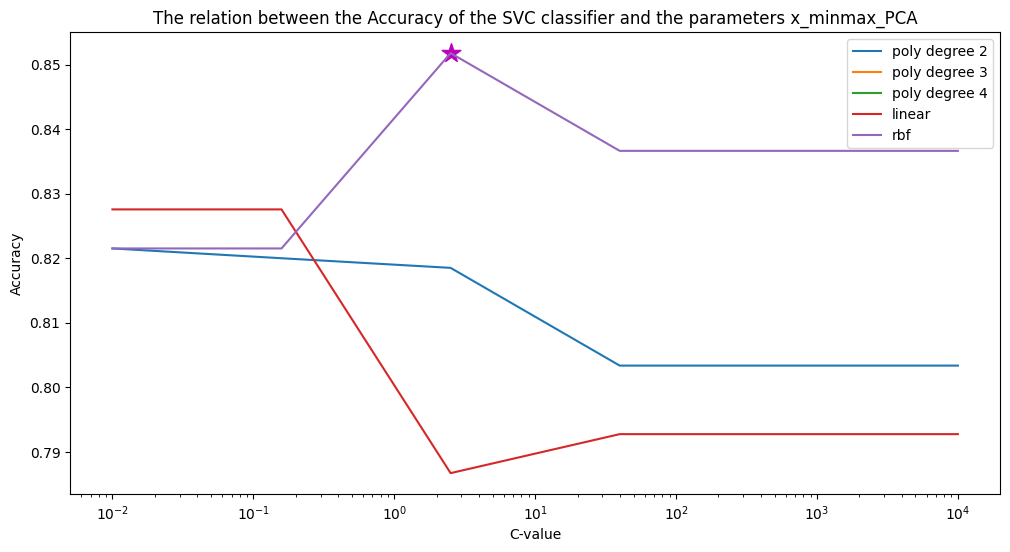

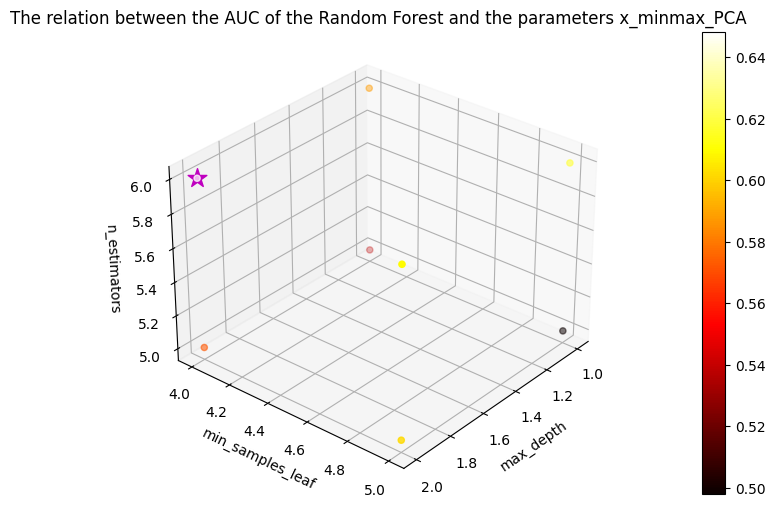

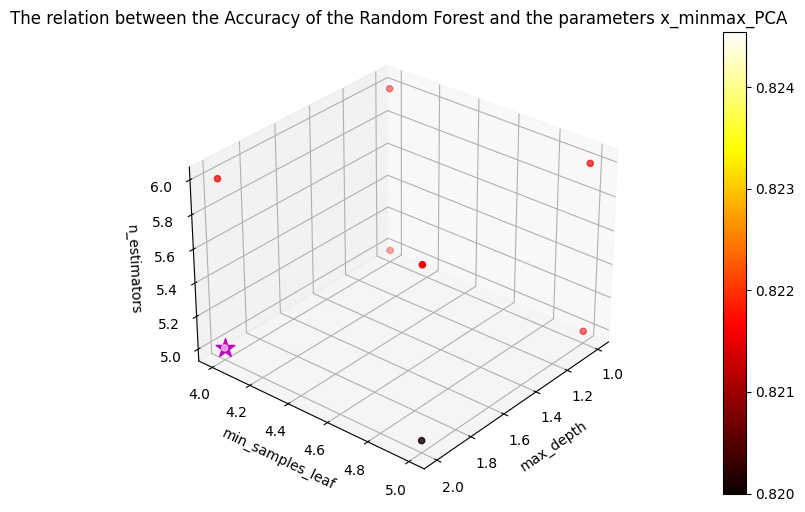

Table of results for combination x_minmax_PCA


<ipython-input-48-9d8bac0373b8>:15: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(pd.DataFrame({"ModelName":model_names, "Accuracy":accuracies, "AUC":AUC}).style.hide_index())


ModelName,Accuracy,AUC
GaussianNB,0.729141,0.594637
DecisionTreeClassifier,0.821451,0.677533
KNeighborsClassifier,0.833630,0.668489
RandomForestClassifier,0.824539,0.648304
SVC,0.851766,0.757173


Grid searching GaussianNB
Grid searching DecisionTreeClassifier
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier
Grid searching SVC


KeyboardInterrupt: ignored

In [49]:
# Perform training
results_all_combinnations = {}
for combination_name, data in x_scaled_pca.items():
  
  # Perform grid search
  scoring = {"AUC":"roc_auc", "Accuracy":"accuracy"} #Determine what type of scoring you want to use
  results = parametertuning(models, model_parameters, 5, None, scoring, "AUC", data, y_train)
  results_all_combinnations[combination_name] = results
  
  # Create all figures
  plot_decisiontree(results, scoring, combination_name)
  plot_knn(results, scoring, combination_name)
  plot_svc(results, scoring, combination_name)
  plot_randomforest(results, scoring, combination_name)

  # Create table with results
  create_table_of_results(results, combination_name)
